In [122]:
import pandas as pd
import glob
import re
import datetime as dt

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt

import pickle

import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection as f_select
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFECV

import scipy.stats as stats

%matplotlib inline

**IMDB Data**

In [2]:
df = pd.read_csv('../../../../../local_files/scrapy_project/tutorial/sequel_movie.csv', thousands=",")

In [3]:
df['year']=df.year.str.replace(r'[^0-9]', '')
df['runtime']=df.runtime.str.replace(r'[^0-9]', '')
df['genre']=df.genre.str.replace(r'[\n ]', '')
df['description']=df.description.str.replace(r'[\n]', '')
df['runtime']=df['runtime'].convert_objects(convert_numeric=True)
df['user_score']=df['user_score']*10

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
df_full = df.dropna()
df_full['year']=list(df_full['year'].apply(lambda x: int(x)))

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [512]:
for i in range(1,5):
    print('actor' + str(i))

actor1
actor2
actor3
actor4


In [6]:
df_full['actor1'] = [str.lower(i).strip() for i in df_full['actor1']]
df_full['actor2'] = [str.lower(i).strip() for i in df_full['actor2']]
df_full['actor3'] = [str.lower(i).strip() for i in df_full['actor3']]
df_full['actor4'] = [str.lower(i).strip() for i in df_full['actor4']]
df_full['director'] = [str.lower(i).strip() for i in df_full['director']]

df_full['actor'] = df_full['actor1']+','+df_full['actor2']+','+df_full['actor3']+','+df_full['actor4']+','+df_full['director']

df_full['genre'] = [str.lower(i).strip() for i in df_full['genre']]


df_full = df_full.drop(["actor1",'actor2','actor3','actor4','director'], axis=1, errors="ignore")

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

**Inflation Data**

In [7]:
inflation_raw = pd.read_csv('../../../../../Metis_Projects/Luther/inflation1.csv')
twentysixteen = inflation_raw[inflation_raw['Year']==2016]
twentysixteen = float(twentysixteen['Avg'])
inflation_raw['twentysixteen'] = twentysixteen
inflation_raw['Year']=list(inflation_raw['Year'].apply(lambda x: int(x)))
inflation_raw.columns = ['year', 'Avg','twentysixteen']
inflation_raw.columns

Index(['year', 'Avg', 'twentysixteen'], dtype='object')

In [8]:
df_full = pd.merge(df_full,inflation_raw,on='year',how='left')
df_full['adj_gross'] = df_full['gross']*df_full['twentysixteen']/df_full['Avg']
df_full = df_full.drop(["gross",'twentysixteen','Avg'], axis=1, errors="ignore")

In [9]:
#test = df_full.dropna()
#test['year']=list(test['year'].apply(lambda x: int(x)))
#len(test)

**Billboard Data**

In [10]:
bbpath = path = '../../../../../local_files/scrapy_project/tutorial/music'
bbdata = pd.read_csv(bbpath+'/billboard.csv')
bbdata["date_bb"] = pd.to_datetime(bbdata.date_bb , format="%B %d, %Y")
bbdata['last_bb']=bbdata.last_bb.str.replace(r'[\–]', '')
bbdata['title_bb']= bbdata['title_bb'].apply(lambda x: x.split(':')[0])
bbdata["title"]=bbdata["title_bb"]
bbdata = bbdata.drop(["title_bb"], axis=1, errors="ignore")
bbdata.head(2)

,peak_bb,date_bb,weeks_bb,last_bb,title
0,1,2016-08-27,24,15,Suicide Squad
1,1,2014-08-23,87,120,Guardians Of The Galaxy


In [11]:
bbdata.head(2)

,peak_bb,date_bb,weeks_bb,last_bb,title
0,1,2016-08-27,24,15,Suicide Squad
1,1,2014-08-23,87,120,Guardians Of The Galaxy


In [12]:
len(bbdata),len(df_full)

(650, 488)

In [13]:
bb_df = pd.merge(df_full,bbdata,on='title',how='left')
bb_df_full = bb_df.dropna()

In [14]:
len(bb_df)

489

In [15]:
df_full.head(2)

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross
0,"action,horror",2016,91.0,3.0,22.0,R,10429.0,Underworld: Blood Wars,"Vampire death dealer, Selene (Kate Beckinsale)...",64.0,"kate beckinsale,theo james,tobias menzies,lara...",23931118.0
1,"action,adventure,crime",2016,118.0,6.0,47.0,PG-13,41325.0,Jack Reacher: Never Go Back,Jack Reacher must uncover the truth behind a m...,61.0,"tom cruise,cobie smulders,aldis hodge,robert k...",58399160.0


In [16]:
bb_df.head(2)

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
0,"action,horror",2016,91.0,3.0,22.0,R,10429.0,Underworld: Blood Wars,"Vampire death dealer, Selene (Kate Beckinsale)...",64.0,"kate beckinsale,theo james,tobias menzies,lara...",23931118.0,NaN,NaT,NaN,NaN
1,"action,adventure,crime",2016,118.0,6.0,47.0,PG-13,41325.0,Jack Reacher: Never Go Back,Jack Reacher must uncover the truth behind a m...,61.0,"tom cruise,cobie smulders,aldis hodge,robert k...",58399160.0,NaN,NaT,NaN,NaN


In [17]:
df_full.tail(2)

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross
486,"comedy,drama",2010,120.0,2152.0,42.0,R,67.0,Queen of the Lot,An electronic ankle bracelet and being under h...,55.0,"tanna frederick,noah wyle,christopher rydell,d...",174161.809952
487,"crime,drama",2002,124.0,2413.0,73.0,R,786.0,Three,In the final chapter of director Belvaux's tri...,71.0,"gilbert melki,lucas belvaux,dominique blanc,or...",34907.077015


In [18]:
bb_df.tail(2)

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
487,"comedy,drama",2010,120.0,2152.0,42.0,R,67.0,Queen of the Lot,An electronic ankle bracelet and being under h...,55.0,"tanna frederick,noah wyle,christopher rydell,d...",174161.809952,NaN,NaT,NaN,NaN
488,"crime,drama",2002,124.0,2413.0,73.0,R,786.0,Three,In the final chapter of director Belvaux's tri...,71.0,"gilbert melki,lucas belvaux,dominique blanc,or...",34907.077015,NaN,NaT,NaN,NaN


In [19]:
len(bb_df)

489

**Dummies**

In [88]:
#bb_df['title'].sort_values(ascending=True)
bb_df[bb_df.duplicated('title')==True]


,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
230,"action,adventure,comedy",2000,98.0,285.0,52.0,PG-13,148361.0,Charlie's Angels,"Three women, detectives with a mysterious boss...",55.0,"cameron diaz,drew barrymore,lucy liu,bill murr...",1.746470e+08,12.0,2003-07-19,8.0,117
371,horror,1981,92.0,534.0,40.0,R,53311.0,Halloween II,While Sheriff Brackett and Dr. Loomis hunt for...,66.0,"jamie lee curtis,donald pleasence,charles cyph...",6.732870e+07,NaN,NaT,NaN,NaN
393,"action,adventure,sci-fi",1998,89.0,586.0,12.0,PG-13,36099.0,The Avengers,Two British agents team up to stop Sir August ...,37.0,"ralph fiennes,uma thurman,sean connery,patrick...",3.434137e+07,NaN,NaT,NaN,NaN


In [21]:
#make_dummies 
actors = bb_df['actor'].str.get_dummies(sep=',') #srt
genres = bb_df['genre'].str.get_dummies(sep=',')
#directors =bb_df['director'].str.get_dummies(sep=',')
all_bi = genres.join([actors])#actors later
bi_cols = pd.DataFrame.sum(all_bi)
#test.sort_values(ascending=False)
#len(actors),len(genres),len(directors),len(all_bi)

In [22]:
#bi_test = genres.join([directors,actors])#actors later

merge_test = actors.merge(directors,how='inner')
merge_test.head()
act_direct_add = actors.add(directors).combine_first(actors)
act_direct_add[act_direct_add['ben stiller']==1]['ben stiller']
actors[actors['ben stiller']==1]['ben stiller']
directors[directors['ben stiller']==1]['ben stiller']
list of actors - those are columns
if actor is in my list then my column name becomes a 1

test = patsy.dmatrix("actor+director",data = bb_df,return_type='dataframe')

unique_acts=[]

for i in bb_df.actors:
    for j in i:
        unique_acts.append(i)
        

In [23]:
fiveup = [bi_cols.index[i] for i in range(len(bi_cols.index)) if bi_cols[i]>5.0]
fiveup = all_bi[fiveup]
for i in fiveup:
    fiveup[i].fillna(0, inplace=True)
#len(fiveup)

/Users/bauer/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
x_metrics = pd.DataFrame(bb_df[['meta_score','user_score','runtime','adj_gross','votes']]) #,'peak_bb','weeks_bb'
#x_metrics['peak_bb'] = x_metrics['peak_bb'].fillna(0, inplace=True)
#x_metrics['weeks_bb'] = x_metrics['weeks_bb'].fillna(0, inplace=True)
#len(x_metrics)

In [25]:
metrics = x_metrics.join(fiveup)
#len(metrics)

**Normalize**

In [26]:
x_process = metrics.dropna()
x_process.head(2)

,meta_score,user_score,runtime,adj_gross,votes,action,adventure,animation,comedy,crime,...,owen wilson,patrick stewart,robert downey jr.,robert rodriguez,rupert grint,sylvester stallone,tommy lee jones,vin diesel,willem dafoe,william shatner
0,22.0,64.0,91.0,23931118.0,10429.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47.0,61.0,118.0,58399160.0,41325.0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#len(x_process)

In [28]:
normed = pd.DataFrame(preprocessing.normalize(x_process, axis=0, norm='max'))
normed.columns = x_process.columns
normed.head(2)

,meta_score,user_score,runtime,adj_gross,votes,action,adventure,animation,comedy,crime,...,owen wilson,patrick stewart,robert downey jr.,robert rodriguez,rupert grint,sylvester stallone,tommy lee jones,vin diesel,willem dafoe,william shatner
0,0.22,0.711111,0.450495,0.013109,0.005982,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.47,0.677778,0.584158,0.031990,0.023704,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#len(test)

** Check Normed**

In [30]:
normed = normed.dropna()
X = normed.drop(["adj_gross"], axis=1, errors="ignore")
y = normed['adj_gross']

print(X.std()[1])
X.mean()[1]

0.126851274418


0.68925244262667584

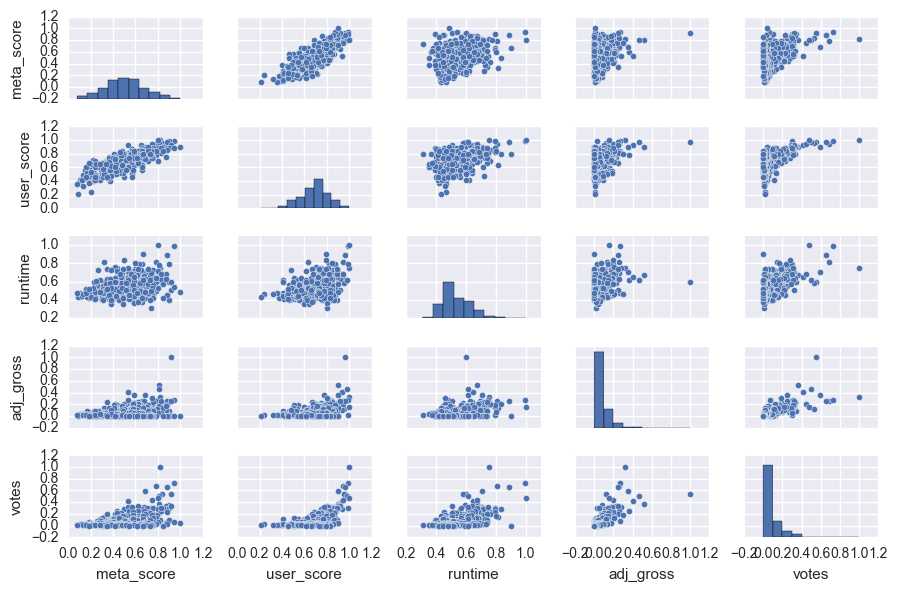

In [31]:
pair_normed = normed[['meta_score','user_score','runtime','adj_gross','votes']]
sns.pairplot(pair_normed, size = 1.2, aspect=1.5)

**SKLearn Predict**

In [32]:
linreg = LinearRegression()

In [33]:
predicted = cross_val_predict(linreg, X, y, cv=10)

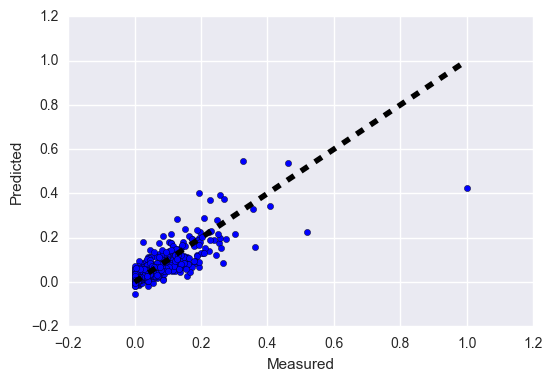

In [34]:
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [35]:
sklearn.metrics.r2_score(y,predicted)

0.61596520406198929

In [36]:
sklearn.metrics.mean_squared_error(y, predicted)

0.0027695956998943874

In [38]:
#plt.scatter(lr.predict())

**Cross Validation**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**RFECV**

In [40]:
linreg = LinearRegression()
X = normed.drop(["adj_gross","meta_score"], axis=1, errors="ignore")
y = normed['adj_gross']
rfecv =   RFECV(estimator=linreg, cv=5)
model = rfecv.fit(X, y)

In [60]:
ranks = pd.DataFrame(rfecv.ranking_)
ranks['col_names']=X.columns
ranks[ranks[0]<=1]

,0,col_names
0,1,user_score
1,1,runtime
2,1,votes
4,1,adventure
5,1,animation
18,1,ben stiller
23,1,eddie murphy
25,1,harrison ford
26,1,ian mckellen
28,1,james doohan


Optimal number of features : 16


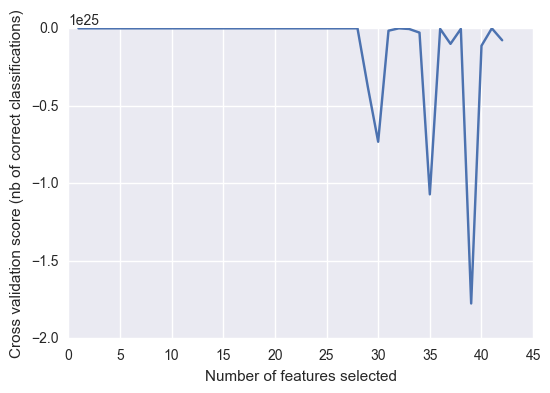

In [42]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [43]:

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [167]:
X = normed.drop(["adj_gross","meta_score"], axis=1, errors="ignore")#,"meta_score","user_score","votes"
y = normed['adj_gross']
y_log=np.log(normed.adj_gross)

In [168]:
len(X)

489

In [169]:
X.head()

,user_score,runtime,votes,action,adventure,animation,comedy,crime,drama,family,...,owen wilson,patrick stewart,robert downey jr.,robert rodriguez,rupert grint,sylvester stallone,tommy lee jones,vin diesel,willem dafoe,william shatner
0,0.711111,0.450495,0.005982,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.677778,0.584158,0.023704,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.700000,0.559406,0.027095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.688889,0.599010,0.039068,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.722222,0.638614,0.077837,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [413]:
mod_1_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj_gross   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     174.9
Date:                Fri, 27 Jan 2017   Prob (F-statistic):          4.81e-151
Time:                        10:06:47   Log-Likelihood:                 716.27
No. Observations:                 441   AIC:                            -1411.
Df Residuals:                     430   BIC:                            -1366.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
votes             0.4747      0.024     19.453      0.000         0.427     0.523
harrison ford     0.2354      0.023     10.101      0.000         0.190     0.281
eddie murphy      0.0743      0.017      4.258      0.000         0.040     0.109
adventure         0.0212      0.005      3.851      0.000         0.010     0.032
animation         0.0280      0.009      3.123      0.002         0.010     0.046
ian mckellen     -0.0633      0.021     -2.953      0.003        -0.106    -0.021
fantasy           0.0172      0.007      2.434      0.015         0.003     0.031
drama            -0.0165      0.006     -2.604      0.010        -0.029    -0.004
runtime           0.0287      0.007      3.835      0.000         0.014     0.043
willem dafoe     -0.0392      0.020     -1.922      0.055        -0.079     0.001
leonard nimoy     0.0177      0.011      1.601      0.110        -0.004     0.039
james doohan      0.0177      0.011      1.601      0.110        -0.004     0.039
==============================================================================
Omnibus:                      308.793   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9088.507
Skew:                           2.560   Prob(JB):                         0.00
Kurtosis:                      24.643   Cond. No.                     6.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.7e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [277]:
kf=KFold(n=len(X),n_folds=10,shuffle=True)

all_scores=[]


# get indices of corresponding train & test
for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
            
    model=sm.OLS(y_train,x_train)
    est=model.fit()
    pvals=est.pvalues.sort_values()
    # we can eliminate features iteratively

    for i in range(5):
        ## recalculate pvalue
        pvals=pvals[:-6]
        ## remove 6 features at a time
        feature_keep=pvals.index
        #print(len(feature_keep))
        
        x_train=x_train[feature_keep]
        x_test=x_test[feature_keep]
        model=sm.OLS(y_train,x_train)
        est=model.fit()
        pvals=est.pvalues.sort_values()
        y_train_pred = est.predict(x_train)
        y_test_pred = est.predict(x_test)
 
    r_2=est.rsquared
    all_scores.append(r_2)

np.mean(all_scores)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj_gross   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     183.5
Date:                Thu, 26 Jan 2017   Prob (F-statistic):          1.97e-148
Time:                        22:45:42   Log-Likelihood:                 710.94
No. Observations:                 441   AIC:                            -1402.
Df Residuals:                     431   BIC:                            -1361.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
votes               0.4669      0.024     19.269      0.000         0.419     0.515
harrison ford       0.1763      0.020      8.959      0.000         0.138     0.215
eddie murphy        0.0812      0.020      4.041      0.000         0.042     0.121
adventure           0.0239      0.005      4.571      0.000         0.014     0.034
runtime             0.0292      0.008      3.793      0.000         0.014     0.044
fantasy             0.0177      0.007      2.473      0.014         0.004     0.032
drama              -0.0143      0.006     -2.216      0.027        -0.027    -0.002
ian mckellen       -0.0552      0.023     -2.387      0.017        -0.101    -0.010
james doohan        0.0140      0.007      1.884      0.060        -0.001     0.029
deforest kelley     0.0140      0.007      1.884      0.060        -0.001     0.029
leonard nimoy       0.0140      0.007      1.884      0.060        -0.001     0.029
ben stiller         0.0281      0.019      1.509      0.132        -0.009     0.065
==============================================================================
Omnibus:                      369.024   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18227.931
Skew:                           3.167   Prob(JB):                         0.00
Kurtosis:                      33.853   Cond. No.                     8.15e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.3e-38. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [379]:
mse1 =est.mse_model
mse1

0.63869575781053223

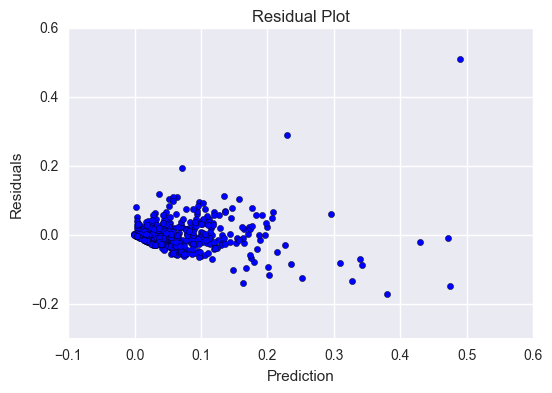

In [279]:
plt.scatter(est.predict(x_train), y_train - est.predict(x_train))
plt.title("Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals")

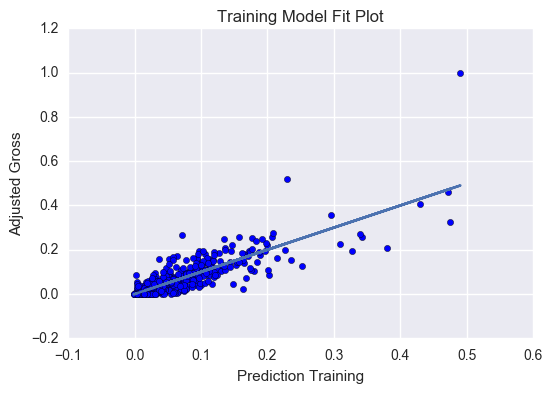

In [280]:
plt.scatter(est.predict(x_train), y_train)
plt.plot(est.predict(x_train),est.predict(x_train))
plt.title("Training Model Fit Plot")
plt.xlabel("Prediction Training")
plt.ylabel("Adjusted Gross")

In [281]:
y_train_index = pd.DataFrame(y_train)
y_train_index.columns = ['value']
y_train_index[y_train_index['value']>=.4]

#pd.DataFrame(y_train)

,value
6,0.519541
15,1.000000
30,0.408045
49,0.462957


In [282]:
residuals = pd.DataFrame(est.resid, columns = ["value"])
residuals[residuals['value']==max(est.resid)]


,value
15,0.509534


In [283]:
bb_df.head(1)

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
0,"action,horror",2016,91.0,3.0,22.0,R,10429.0,Underworld: Blood Wars,"Vampire death dealer, Selene (Kate Beckinsale)...",64.0,"kate beckinsale,theo james,tobias menzies,lara...",23931118.0,NaN,NaT,NaN,NaN


In [284]:
X.shape

(489, 42)

In [285]:
X[X.duplicated()==True]

,user_score,runtime,votes,action,adventure,animation,comedy,crime,drama,family,...,owen wilson,patrick stewart,robert downey jr.,robert rodriguez,rupert grint,sylvester stallone,tommy lee jones,vin diesel,willem dafoe,william shatner
230,0.611111,0.485149,0.0851,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


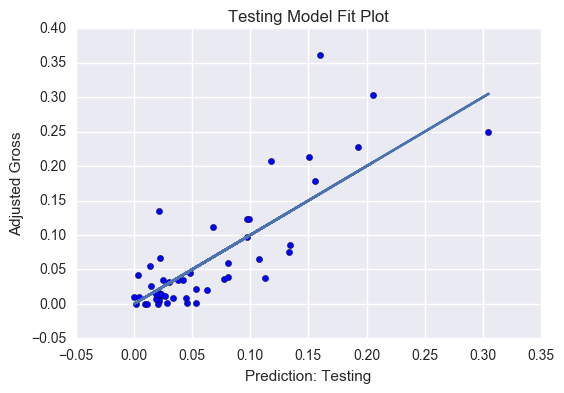

In [286]:
plt.scatter(est.predict(x_test), y_test)
plt.plot(est.predict(x_test),est.predict(x_test))
plt.title("Testing Model Fit Plot")
plt.xlabel("Prediction: Testing")
plt.ylabel("Adjusted Gross")

In [289]:
y_test_index = pd.DataFrame(y_test)
y_test_index.columns = ['value']
y_test_index[y_test_index['value']>=.24]

,value
26,0.361758
75,0.248823
204,0.303778


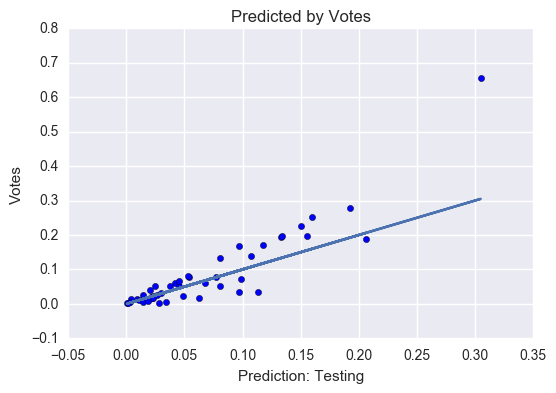

In [287]:
plt.scatter(est.predict(x_test), x_test.votes)
plt.plot(est.predict(x_test),est.predict(x_test))
plt.title("Predicted by Votes")
plt.xlabel("Prediction: Testing")
plt.ylabel("Votes")

In [293]:
x_test[x_test.votes>=.26]

,votes,harrison ford,eddie murphy,adventure,runtime,fantasy,drama,ian mckellen,james doohan,deforest kelley,leonard nimoy,ben stiller
72,0.278625,0.0,0.0,1.0,0.702970,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.657052,0.0,0.0,1.0,0.886139,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [290]:
bb_df.query('index ==26')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
26,"action,adventure,sci-fi",2015,124.0,44.0,59.0,PG-13,440377.0,Jurassic World,"A new theme park, built on the original site o...",70.0,"chris pratt,bryce dallas howard,ty simpkins,ju...",6.604046e+08,NaN,NaT,NaN,NaN


In [291]:
bb_df.query('index ==75')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
75,"adventure,drama,fantasy",2002,179.0,98.0,88.0,PG-13,1145490.0,The Lord of the Rings: The Two Towers,While Frodo and Sam edge closer to Mordor with...,87.0,"elijah wood,ian mckellen,viggo mortensen,orlan...",4.542375e+08,NaN,NaT,NaN,NaN


In [292]:
bb_df.query('index ==204')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
204,"animation,adventure,comedy",2004,93.0,251.0,75.0,PG,326278.0,Shrek 2,Princess Fiona's parents invite her and Shrek ...,72.0,"kelly asbury,conrad vernon,mike myers,eddie mu...",5.545585e+08,8.0,2004-06-19,41.0,


In [236]:
bb_df.query('index ==6')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
6,"action,adventure,fantasy",2015,136.0,19.0,81.0,PG-13,629140.0,Star Wars: The Force Awakens,Three decades after the defeat of the Galactic...,81.0,"daisy ridley,john boyega,oscar isaac,domhnall ...",9.484431e+08,NaN,NaT,NaN,NaN


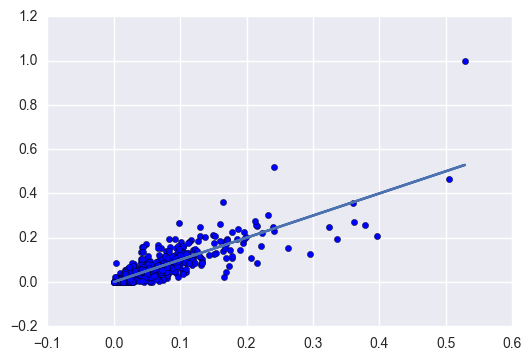

In [237]:
plt.scatter(est.predict(x_train), y_train)
plt.plot(est.predict(x_train),est.predict(x_train))

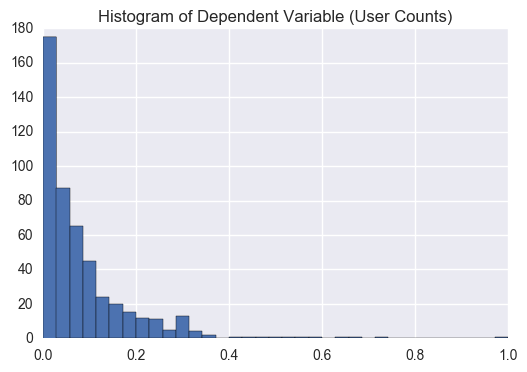

In [206]:
X.votes.hist(bins=35)
plt.title('Histogram of Dependent Variable (User Counts)')

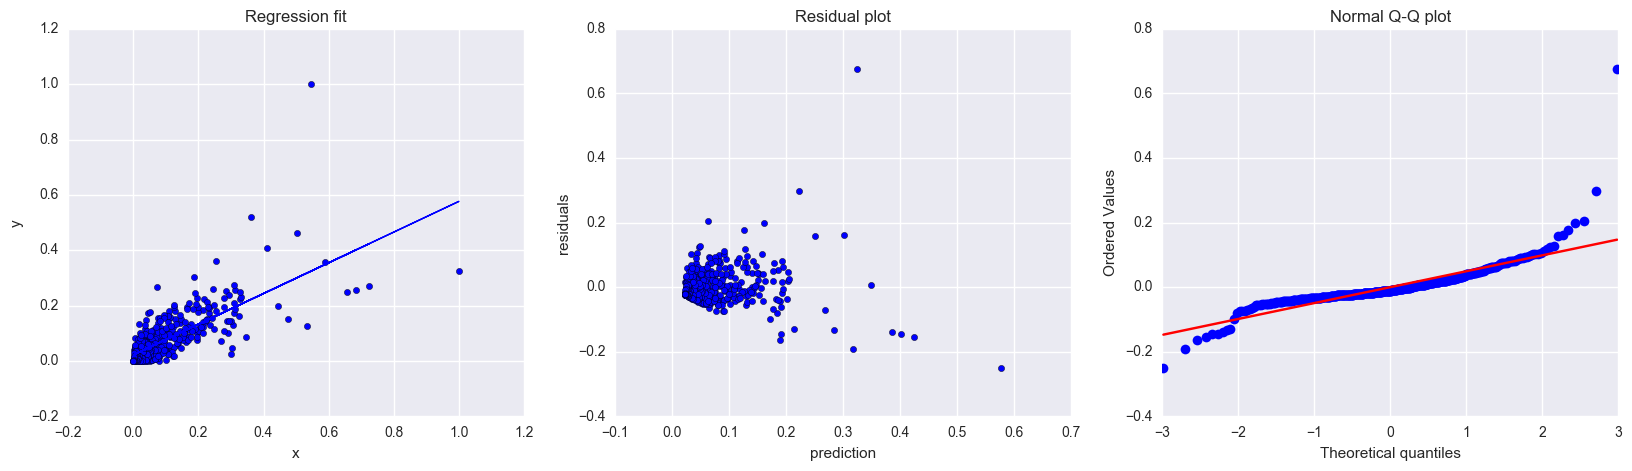

In [294]:
s=len(X)

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
diagnostic_plot(X['votes'], y)

In [381]:
mse2 =est2.mse_model
mse2, max(X['votes'])

(0.5975428349168922, 1.0)

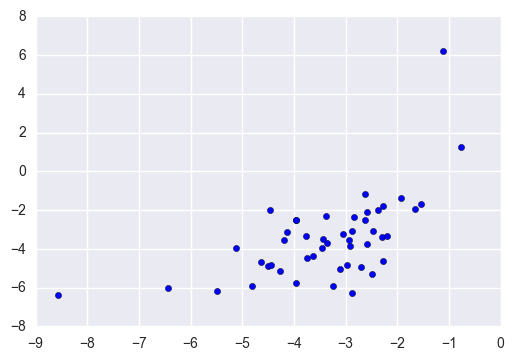

In [208]:
plt.scatter(y_test,y_test_pred)

**Take Two**

In [325]:
X2 = normed[["votes","runtime","adventure", "animation","fantasy", "drama", "user_score"]]#,"meta_score","user_score","votes"
#X2['votes'] = np.log(normed.votes)
y = normed['adj_gross']
y_log=np.log(normed.adj_gross)

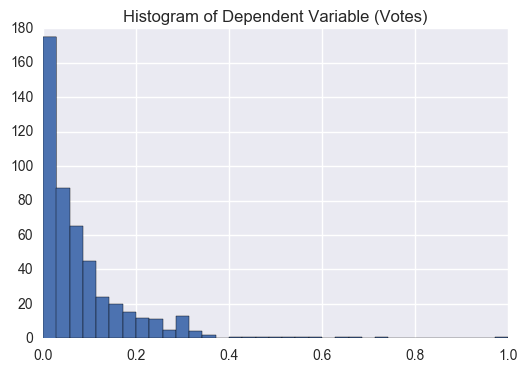

In [326]:
X2.votes.hist(bins=35)
plt.title('Histogram of Dependent Variable (Votes)')

In [327]:
kf=KFold(n=len(X),n_folds=10,shuffle=True)

all_scores=[]


# get indices of corresponding train & test
for train,test in kf:
    x_train2=X2.iloc[train]
    y_train2=y.iloc[train]
    x_test2=X2.iloc[test]
    y_test2=y.iloc[test]
    pvals=[]
    sig_cols=[]
            
    model2=sm.OLS(y_train2,x_train2)
    est2=model2.fit()
    pvals=est2.pvalues.sort_values()
    r_22=est2.rsquared
    all_scores.append(r_22)

np.mean(all_scores)
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj_gross   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     198.3
Date:                Thu, 26 Jan 2017   Prob (F-statistic):          6.91e-131
Time:                        23:19:40   Log-Likelihood:                 657.67
No. Observations:                 441   AIC:                            -1301.
Df Residuals:                     434   BIC:                            -1273.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
votes          0.5154      0.027     18.854      0.000         0.462     0.569
runtime        0.0100      0.029      0.344      0.731        -0.047     0.067
adventure      0.0205      0.006      3.271      0.001         0.008     0.033
animation      0.0275      0.011      2.610      0.009         0.007     0.048
fantasy        0.0183      0.008      2.369      0.018         0.003     0.034
drama         -0.0192      0.007     -2.667      0.008        -0.033    -0.005
user_score     0.0158      0.023      0.692      0.490        -0.029     0.061
==============================================================================
Omnibus:                      468.757   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45985.604
Skew:                           4.431   Prob(JB):                         0.00
Kurtosis:                      52.235   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

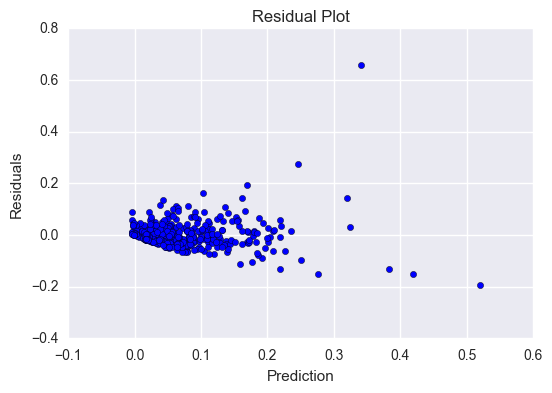

In [336]:
plt.scatter(est2.predict(x_train2), y_train2 - est2.predict(x_train2))
plt.title("Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals")

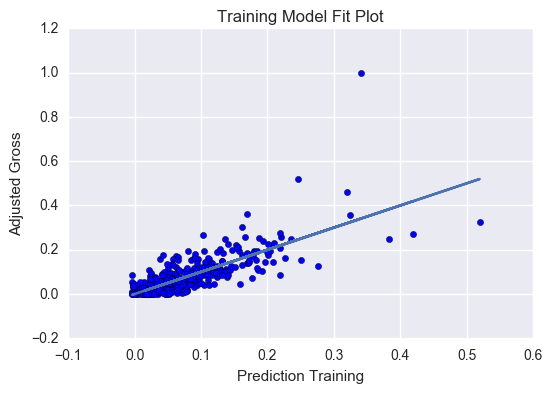

In [337]:
plt.scatter(est2.predict(x_train2), y_train2)
plt.plot(est2.predict(x_train2),est2.predict(x_train2))
plt.title("Training Model Fit Plot")
plt.xlabel("Prediction Training")
plt.ylabel("Adjusted Gross")

In [348]:
y_train2_index = pd.DataFrame(y_train2)
y_train2_index.columns = ['value']
y_train2_index[y_train2_index['value']>=.32]

,value
6,0.519541
11,0.325662
15,1.000000
26,0.361758
42,0.356907
49,0.462957


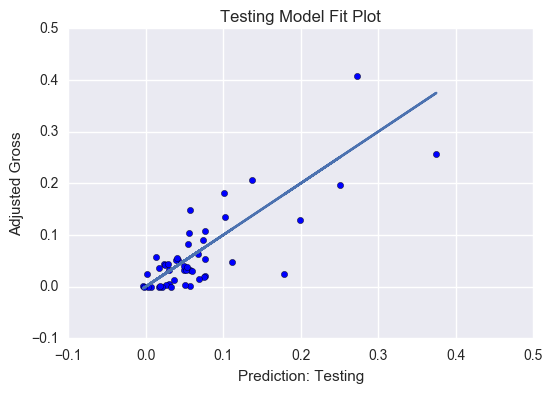

In [338]:
plt.scatter(est2.predict(x_test2), y_test2)
plt.plot(est2.predict(x_test2),est2.predict(x_test2))
plt.title("Testing Model Fit Plot")
plt.xlabel("Prediction: Testing")
plt.ylabel("Adjusted Gross")

In [343]:
y_test2_index = pd.DataFrame(y_test2)
y_test2_index.columns = ['value']
y_test2_index[y_test2_index['value']>=.19]

,value
18,0.256612
30,0.408045
52,0.197732
87,0.205946


In [352]:
bb_df.query('index ==18')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
18,"action,thriller",2012,164.0,36.0,78.0,PG-13,1190537.0,The Dark Knight Rises,Eight years after the Joker's reign of anarchy...,85.0,"christian bale,tom hardy,anne hathaway,gary ol...",4.684551e+08,NaN,NaT,NaN,NaN


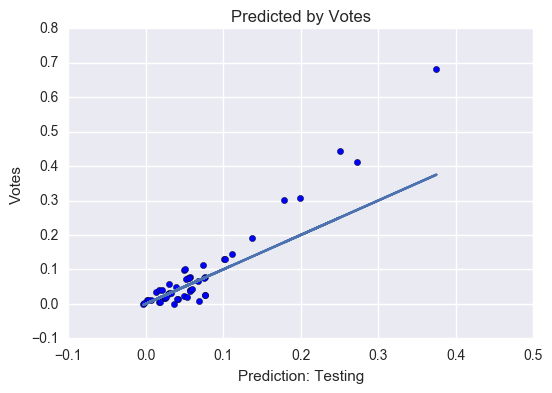

In [339]:
plt.scatter(est2.predict(x_test2), x_test2.votes)
plt.plot(est2.predict(x_test2),est2.predict(x_test2))
plt.title("Predicted by Votes")
plt.xlabel("Prediction: Testing")
plt.ylabel("Votes")

In [360]:
x_test2[x_test2.votes>=.3]

,votes,runtime,adventure,animation,fantasy,drama,user_score
18,0.682891,0.811881,0.0,0.0,0.0,0.0,0.944444
30,0.411723,0.648515,1.0,0.0,1.0,0.0,0.933333
45,0.300311,0.797030,0.0,0.0,0.0,0.0,0.988889
50,0.306316,0.653465,1.0,0.0,0.0,0.0,0.888889
52,0.443654,0.678218,0.0,0.0,0.0,0.0,0.944444


In [374]:
bb_df.query('index ==52')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
52,"action,sci-fi",1991,137.0,73.0,75.0,R,773456.0,Terminator 2: Judgment Day,"A cyborg, identical to the one who failed to k...",85.0,"arnold schwarzenegger,linda hamilton,edward fu...",3.609680e+08,NaN,NaT,NaN,NaN


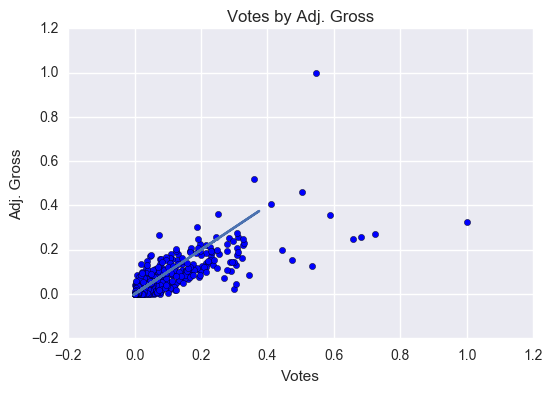

In [362]:
plt.scatter(X.votes, y)
plt.plot(est2.predict(x_test2),est2.predict(x_test2))
plt.title("Votes by Adj. Gross")
plt.xlabel("Votes")
plt.ylabel("Adj. Gross")

In [363]:
X[X.votes>=.57]

,user_score,runtime,votes,action,adventure,animation,comedy,crime,drama,family,...,owen wilson,patrick stewart,robert downey jr.,robert rodriguez,rupert grint,sylvester stallone,tommy lee jones,vin diesel,willem dafoe,william shatner
11,1.000000,0.752475,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.944444,0.811881,0.682891,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.988889,0.995050,0.725208,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.900000,0.707921,0.589148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.966667,0.886139,0.657052,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [368]:
bb_df.query('index ==18')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
18,"action,thriller",2012,164.0,36.0,78.0,PG-13,1190537.0,The Dark Knight Rises,Eight years after the Joker's reign of anarchy...,85.0,"christian bale,tom hardy,anne hathaway,gary ol...",4.684551e+08,NaN,NaT,NaN,NaN


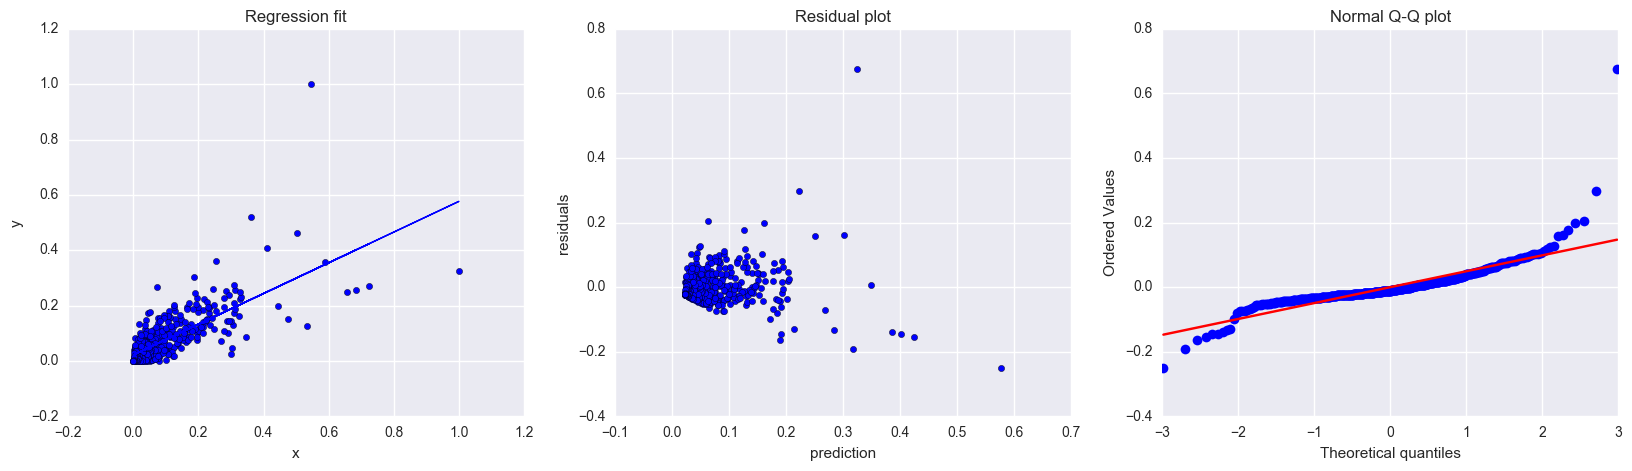

In [340]:
diagnostic_plot(X['votes'], y)

In [375]:
X3 = normed[["votes","runtime","adventure", "animation","fantasy", "drama", "user_score"]]#,"meta_score","user_score","votes"
X3['votes'] = np.log(X3.votes)
kf=KFold(n=len(X),n_folds=10,shuffle=True)

all_scores=[]


# get indices of corresponding train & test
for train,test in kf:
    x_train3=X3.iloc[train]
    y_train3=y_log.iloc[train]
    x_test3=X3.iloc[test]
    y_test3=y_log.iloc[test]
    pvals=[]
    sig_cols=[]
            
    model3=sm.OLS(y_train3,x_train3)
    est3=model3.fit()
    pvals=est3.pvalues.sort_values()
    r_23=est3.rsquared
    all_scores.append(r_23)
    mse3 =est3.mse_model

np.mean(all_scores)
est3.summary()

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj_gross   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     373.1
Date:                Fri, 27 Jan 2017   Prob (F-statistic):          3.45e-179
Time:                        09:18:34   Log-Likelihood:                -845.87
No. Observations:                 441   AIC:                             1706.
Df Residuals:                     434   BIC:                             1734.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
votes          1.0371      0.050     20.846      0.000         0.939     1.135
runtime        1.9031      0.878      2.167      0.031         0.177     3.629
adventure      0.7175      0.190      3.767      0.000         0.343     1.092
animation      1.1411      0.328      3.481      0.001         0.497     1.785
fantasy        0.0404      0.240      0.168      0.866        -0.431     0.512
drama         -0.2041      0.217     -0.941      0.347        -0.631     0.222
user_score    -2.6279      0.654     -4.021      0.000        -3.912    -1.343
==============================================================================
Omnibus:                      210.029   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.433
Skew:                          -2.048   Prob(JB):                    8.28e-244
Kurtosis:                       9.645   Cond. No.                         48.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

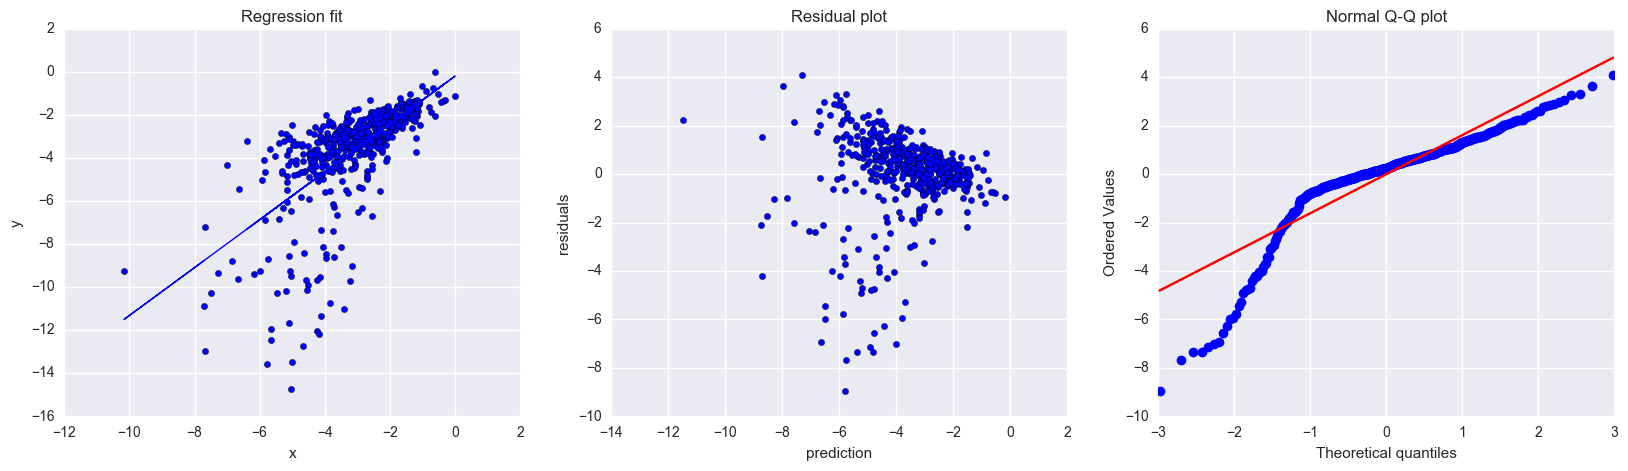

In [376]:
diagnostic_plot(X3['votes'], y_log)

In [384]:
mse3 =est3.mse_model
mse3, max(X3['votes'])

(1028.756479384052, 0.0)

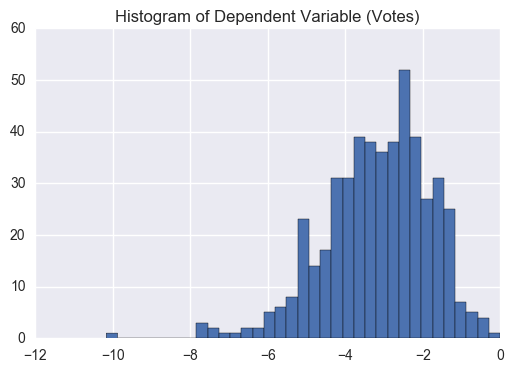

In [385]:
X3.votes.hist(bins=35)
plt.title('Histogram of Dependent Variable (Log Votes)')

In [497]:
def model_ols(X, y, xvar, yvar, folds):
    kf=KFold(n=len(X),n_folds=10,shuffle=True)

    all_scores=[]


# get indices of corresponding train & test
    for train,test in kf:
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        pvals=[]
        sig_cols=[]
                
        model=sm.OLS(y_train,x_train)
        est=model.fit()
        pvals=est.pvalues.sort_values()
        # we can eliminate features iteratively

        for i in range(1):
            ## recalculate pvalue
            pvals=pvals[:-1]
            ## remove 6 features at a time
            feature_keep=pvals.index
            #print(len(feature_keep))
        
            x_train=x_train[feature_keep]
            x_test=x_test[feature_keep]
            model=sm.OLS(y_train,x_train)
            est=model.fit()
            pvals=est.pvalues.sort_values()
            y_train_pred = est.predict(x_train)
            y_test_pred = est.predict(x_test)
     
        r_2=est.rsquared
        mse1 =est.mse_model
        all_scores.append(r_2)
        all_scores.append(mse1)

    np.mean(all_scores)
    est.summary()
    
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.scatter(est.predict(x_train), y_train - est.predict(x_train))
    plt.title("Residual Plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    
    plt.subplot(2, 2, 2)
    plt.scatter(est.predict(x_train), y_train)
    plt.plot(est.predict(x_train),est.predict(x_train))
    plt.title("Training Model Fit Plot")
    plt.xlabel("Prediction: Training")
    plt.ylabel(str(yvar))
    
    plt.subplot(2, 2, 3)
    plt.scatter(est.predict(x_test), y_test)
    plt.plot(est.predict(x_test),est.predict(x_test))
    plt.title("Testing Model Fit Plot")
    plt.xlabel("Prediction: Testing")
    plt.ylabel(str(yvar))
    
    plt.subplot(2, 2, 4)
    plt.scatter(est.predict(x_test), x_test.votes)
    plt.plot(est.predict(x_test),est.predict(x_test))
    plt.title("Predicted by Votes")
    plt.xlabel("Prediction: Testing")
    plt.ylabel(str(xvar))
    
    plt.tight_layout()
    return(fig,est.summary(),mse1, y_test,x_test)

In [498]:
normed_noout = normed[normed['votes']<.4]
normed_noout = normed_noout[normed_noout['adj_gross']<.4]
normed_noout.head()

,meta_score,user_score,runtime,adj_gross,votes,action,adventure,animation,comedy,crime,...,owen wilson,patrick stewart,robert downey jr.,robert rodriguez,rupert grint,sylvester stallone,tommy lee jones,vin diesel,willem dafoe,william shatner
0,0.22,0.711111,0.450495,0.013109,0.005982,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.47,0.677778,0.584158,0.031990,0.023704,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.34,0.700000,0.559406,0.042200,0.027095,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.42,0.688889,0.599010,0.018766,0.039068,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.46,0.722222,0.638614,0.035623,0.077837,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [499]:
X4 = normed_noout[["votes","runtime","adventure", "animation","fantasy", "drama", "user_score"]]#,"meta_score","user_score","votes"
y4 = normed_noout['adj_gross']
#X4['votes'] = np.log(X4.votes)
#X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X4, y4, test_size=0.3)
len(X4), len(y4)

(477, 477)

Figure(720x720)                             OLS Regression Results                            
Dep. Variable:              adj_gross   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     316.0
Date:                Fri, 27 Jan 2017   Prob (F-statistic):          5.07e-153
Time:                        12:23:37   Log-Likelihood:                 787.95
No. Observations:                 430   AIC:                            -1564.
Df Residuals:                     424   BIC:                            -1540.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
votes          0.5502      0.029    

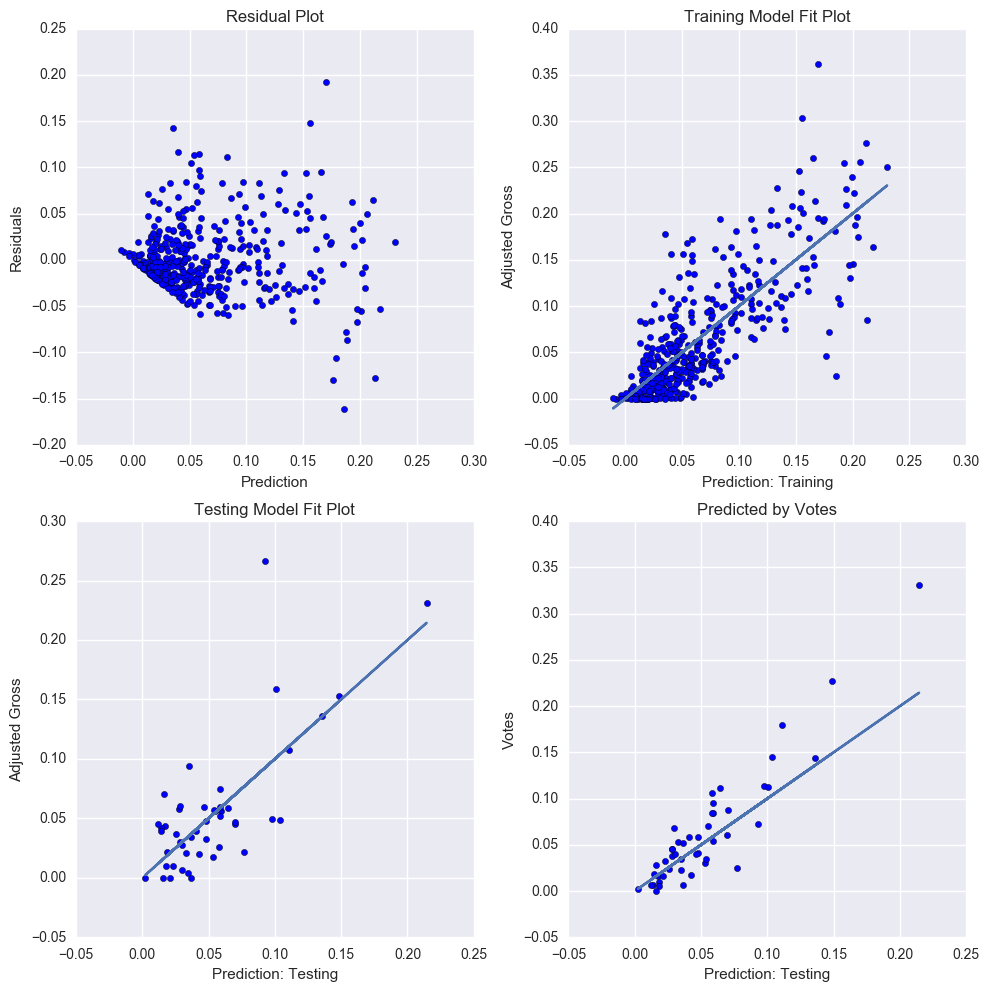

In [501]:
mod_test1,mod_1_sum,mod_1_mse,y4_test,x4_test = model_ols(X4,y4,'Votes','Adjusted Gross',10)
print(mod_test1,mod_1_sum,mod_1_mse)

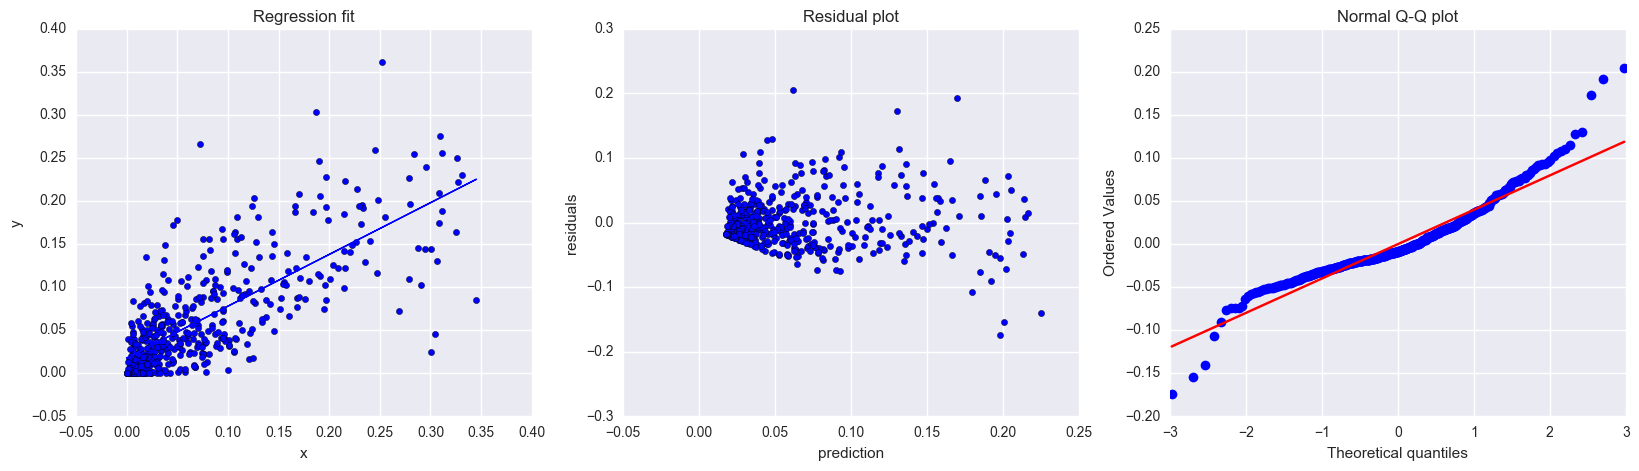

In [502]:
s=len(X4)
diagnostic_plot(X4['votes'], y4)

In [508]:
y_test4_index = pd.DataFrame(y4_test)
y_test4_index.columns = ['value']
y_test4_index[y_test4_index['value']>=.2]

,value
17,0.266383
83,0.230819


In [506]:
x4_test[x4_test.votes>=.2]

,votes,animation,runtime,adventure,user_score,drama
83,0.330684,0.0,0.643564,1.0,0.800000,0.0
152,0.226887,0.0,0.514851,1.0,0.744444,0.0


In [509]:
bb_df.query('index ==152')

,genre,year,runtime,popularity,meta_score,rating,votes,title,description,user_score,actor,adj_gross,peak_bb,date_bb,weeks_bb,last_bb
152,"action,adventure,fantasy",2006,104.0,191.0,58.0,PG-13,395550.0,X-Men: The Last Stand,"When a cure is found to treat mutations, lines...",67.0,"patrick stewart,hugh jackman,halle berry,famke...",2.790082e+08,NaN,NaT,NaN,NaN
